# RNN application to a time series problem

**Notebook made by: André Reis & Gonçalo Freitas, University of Aveiro ©**

References : 

https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from datetime import datetime
import sys
from matplotlib import pyplot
from keras.layers import Bidirectional

#from read_files import read_files

import matplotlib.pyplot as plt

import math
from sklearn.metrics import mean_squared_error

p = 0

# Setup variables

In [2]:
if p == 2:
    path = "time_series/"
if p == 1:
    path = "D:/OneDrive - Universidade de Aveiro/Mestrado/4 ano/1 semestre/AIA/Modulo 2/Projeto/time_series/"
if p == 0:
    path = "C:/Users/OMEN/OneDrive - Universidade de Aveiro/Mestrado/4 ano/1 semestre/AIA/Modulo 2/Projeto/time_series/"
    
product_group_id = 958
time_series_folder = 1 #1,2,3

product_information = pd.read_pickle(path+"Data/product_information")
print(product_information.loc[product_group_id])

empresa = "Ripley"    # company we gonna study

product       huawei Y9S 128GB
offer_type            unlocked
Name: 958, dtype: object


# Get data

In [3]:
df_long = pd.read_pickle(path+"Data/time_series_"+str(time_series_folder)+"/long_product_group_id_" + str(product_group_id))
df_wide = df_long.reset_index().groupby(['timestamp', "company"])["price"].first().unstack().reset_index().set_index("timestamp")

# Fill missing timestamps
timestamps  = pd.DataFrame(index = pd.date_range(df_wide.index[0],df_wide.index[-1], freq='D'))
df_wide = pd.merge(timestamps, df_wide, left_index = True, right_index = True, how = 'left')
df_wide.columns.name = None

**Data Overview**

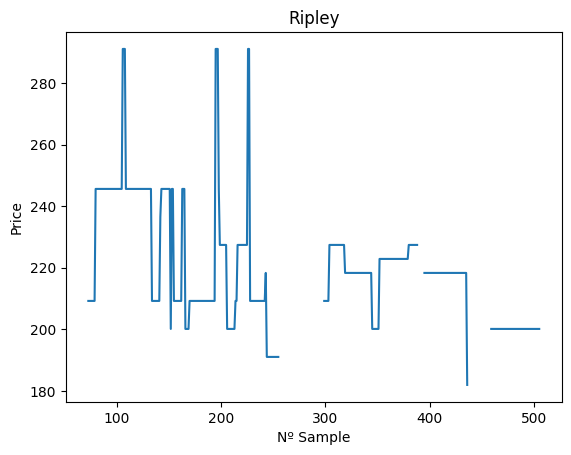

In [4]:
df_wide.columns
values = df_wide.values

# plot each column

plt.figure()
plt.plot(values[:, 4])
plt.xlabel('Nº Sample')
plt.ylabel('Price')
plt.title(df_wide.columns[4])
plt.show()

<Figure size 640x480 with 0 Axes>

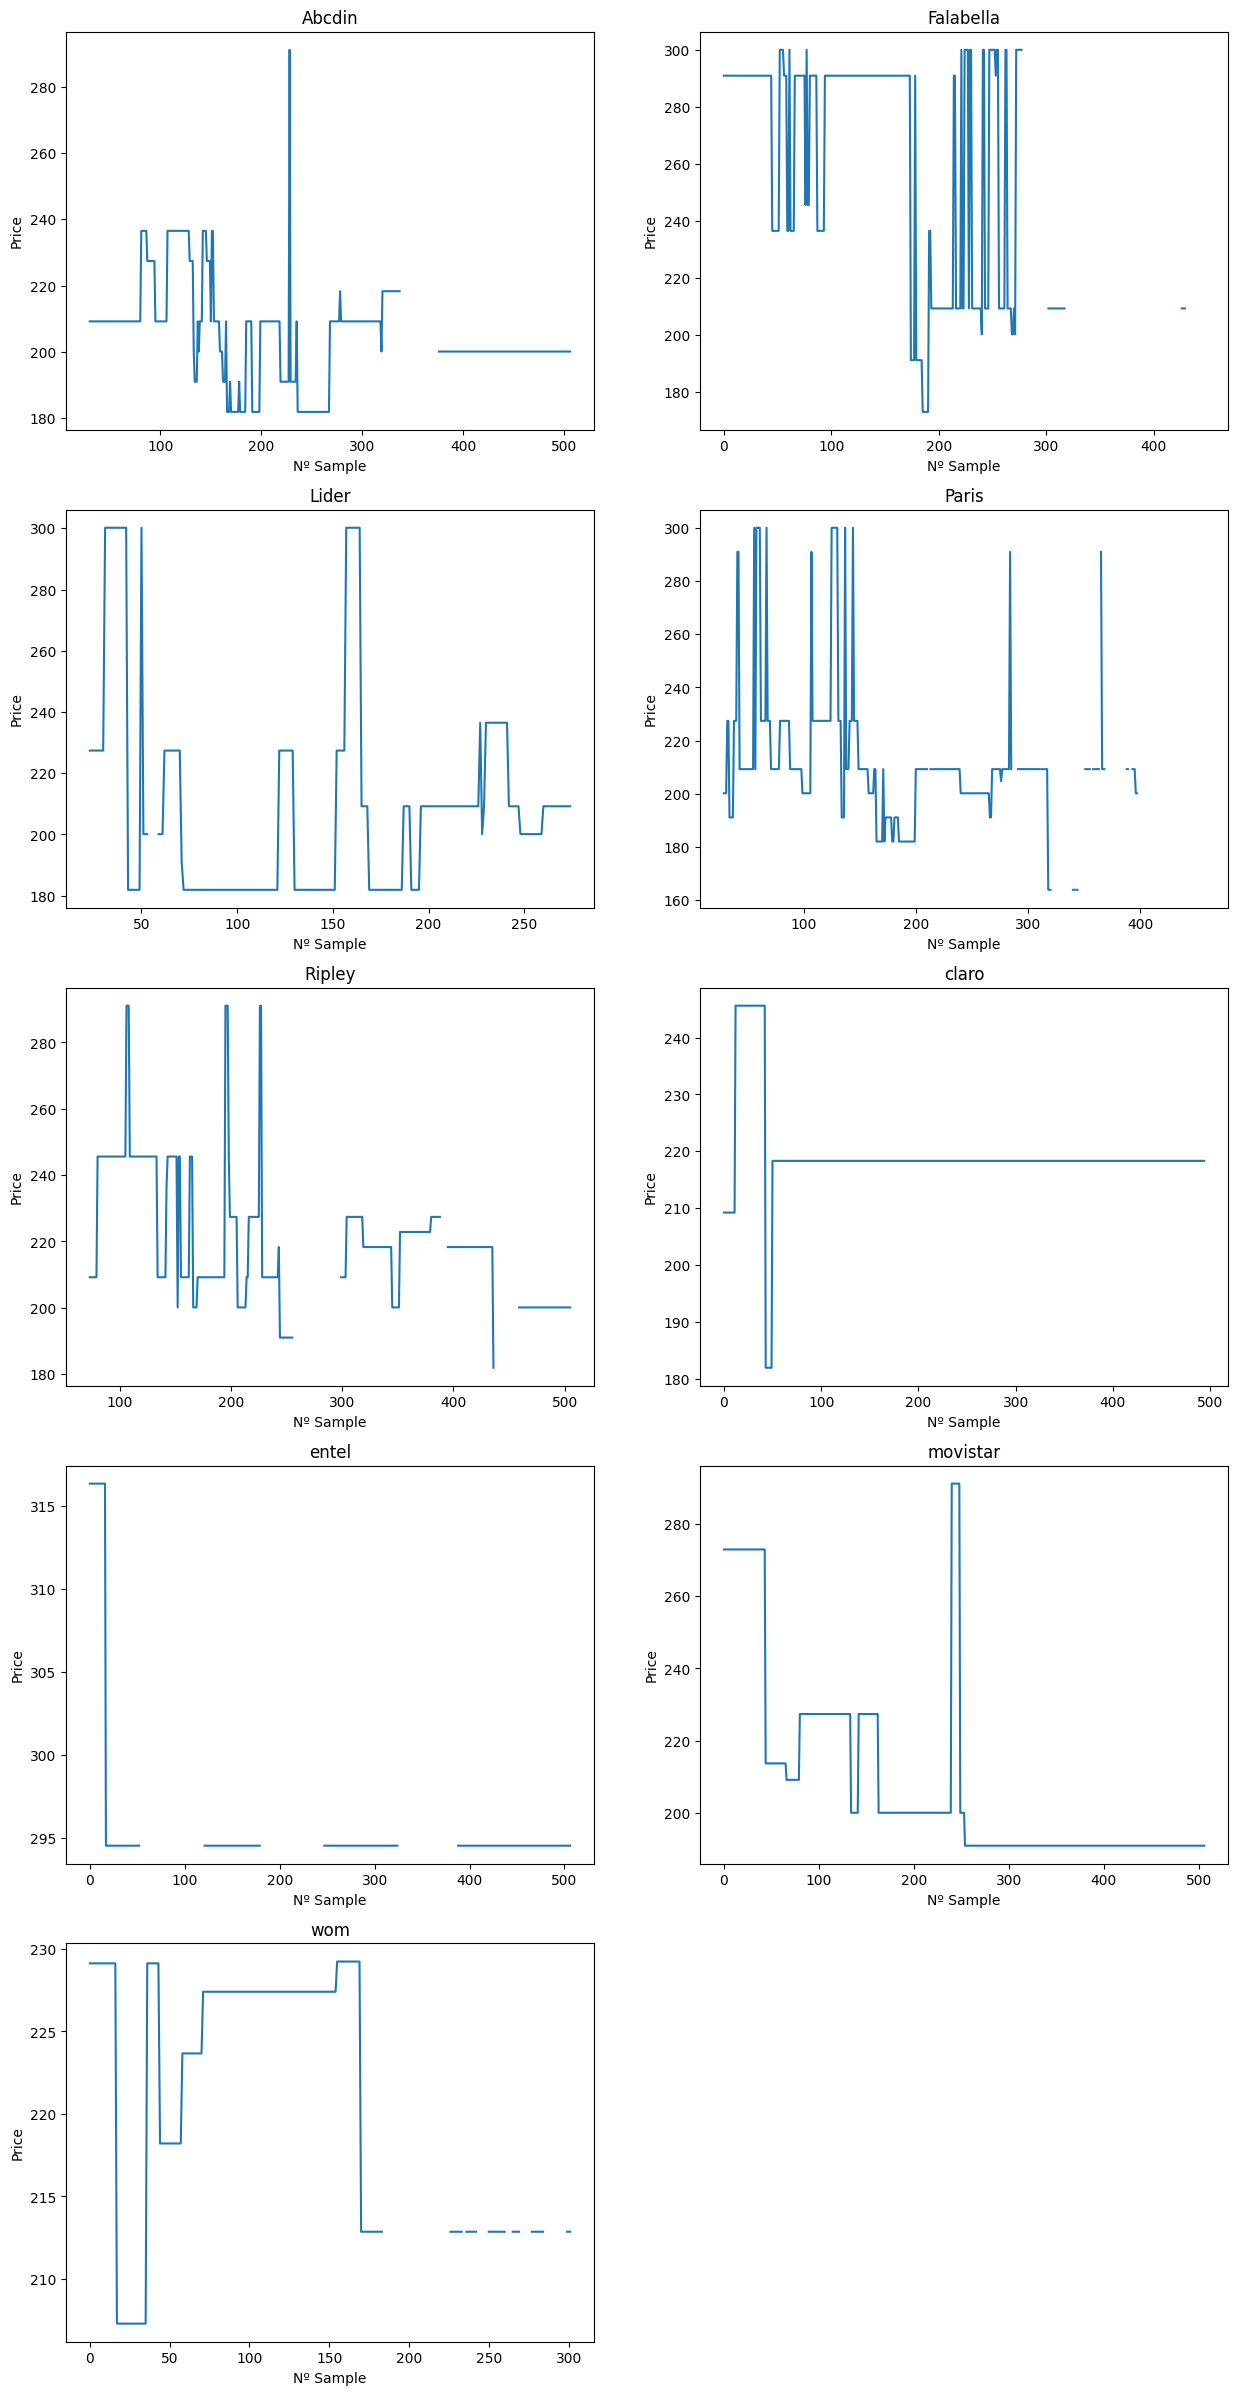

In [5]:
df_wide.columns
values = df_wide.values

# plot each column
columns = [0, 1, 2, 3, 4, 5, 6, 7, 8]
i = 1
plt.figure()
f = plt.figure(figsize=(15,30))
for col in columns:
    plt.subplot(5, 2, i)
    plt.plot(values[:, col])
    plt.xlabel('Nº Sample')
    plt.ylabel('Price')
    plt.title(df_wide.columns[col])
    i += 1
plt.show()

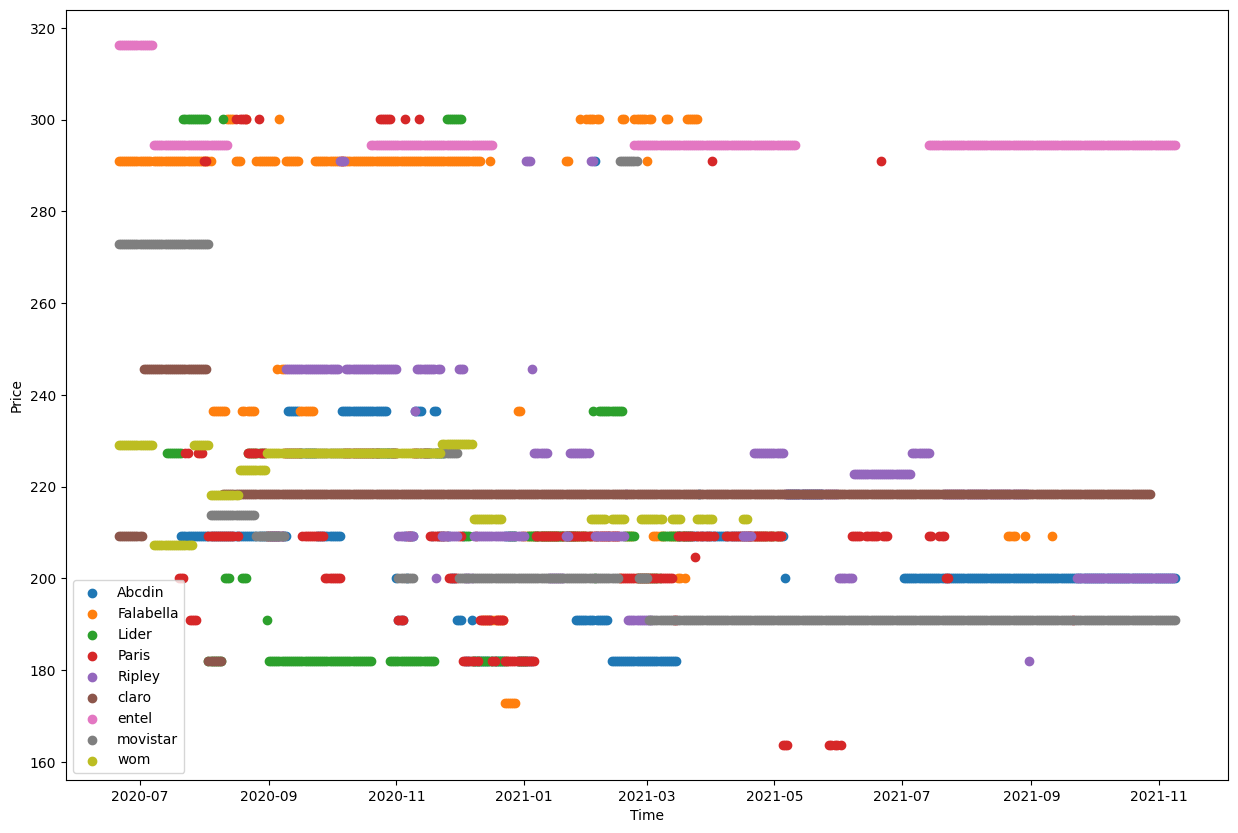

In [6]:
plt.figure(figsize=(15, 10))
for name in df_wide.columns:
    plt.scatter(df_wide.index, df_wide[name])
plt.legend(df_wide.columns)
plt.xlabel('Time')
plt.ylabel('Price')
plt.savefig(path+"product_"+str(product_group_id)+".png",dpi=600,format="png")

**Interpolate to fix the NaN values and substitute them with a estimation of the value in that time**

In [7]:
"""
df_wide = df_wide.fillna(df_wide.mean())
"""
methods= ["linear","time","slinear","quadratic","cubic","barycentric",
        "krogh", "from_derivatives", "pchip", "akima", "cubicspline"]
orders = ["polynomial","spline"]
methods += orders
order = 5

method = methods[1]
#for name in df_wide.columns:
if method in orders:
    df_wide.interpolate(option=method,order=order,inplace=True,limit_direction="both")
else:
    df_wide.interpolate(option=method,inplace=True,limit_direction="both")
print(df_wide)

                Abcdin   Falabella       Lider       Paris      Ripley  \
2020-06-21  209.214955  291.085236  227.408351  200.118257  209.214955   
2020-06-22  209.214955  291.085236  227.408351  200.118257  209.214955   
2020-06-23  209.214955  291.085236  227.408351  200.118257  209.214955   
2020-06-24  209.214955  291.085236  227.408351  200.118257  209.214955   
2020-06-25  209.214955  291.085236  227.408351  200.118257  209.214955   
...                ...         ...         ...         ...         ...   
2021-11-05  200.118257  209.214955  209.214955  191.021559  200.118257   
2021-11-06  200.118257  209.214955  209.214955  191.021559  200.118257   
2021-11-07  200.118257  209.214955  209.214955  191.021559  200.118257   
2021-11-08  200.118257  209.214955  209.214955  191.021559  200.118257   
2021-11-09  200.118257  209.214955  209.214955  191.021559  200.118257   

                 claro       entel    movistar         wom  
2020-06-21  209.214955  316.346766  272.891840  22

**Data overview after interpolation**

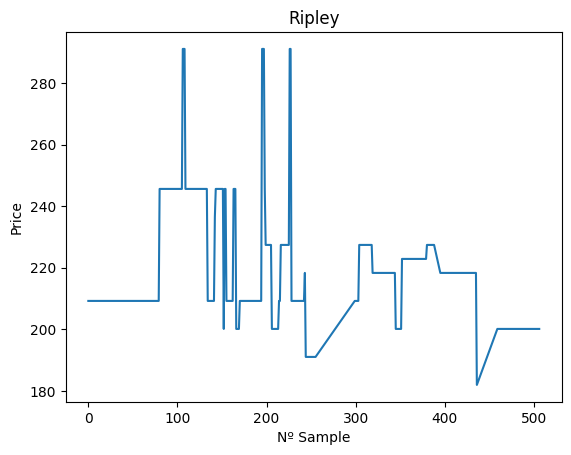

In [8]:
df_wide.columns
values = df_wide.values

plt.figure()
plt.plot(values[:, 4])
plt.xlabel('Nº Sample')
plt.ylabel('Price')
plt.title(df_wide.columns[4])
plt.show()

<Figure size 640x480 with 0 Axes>

<Figure size 1500x2000 with 0 Axes>

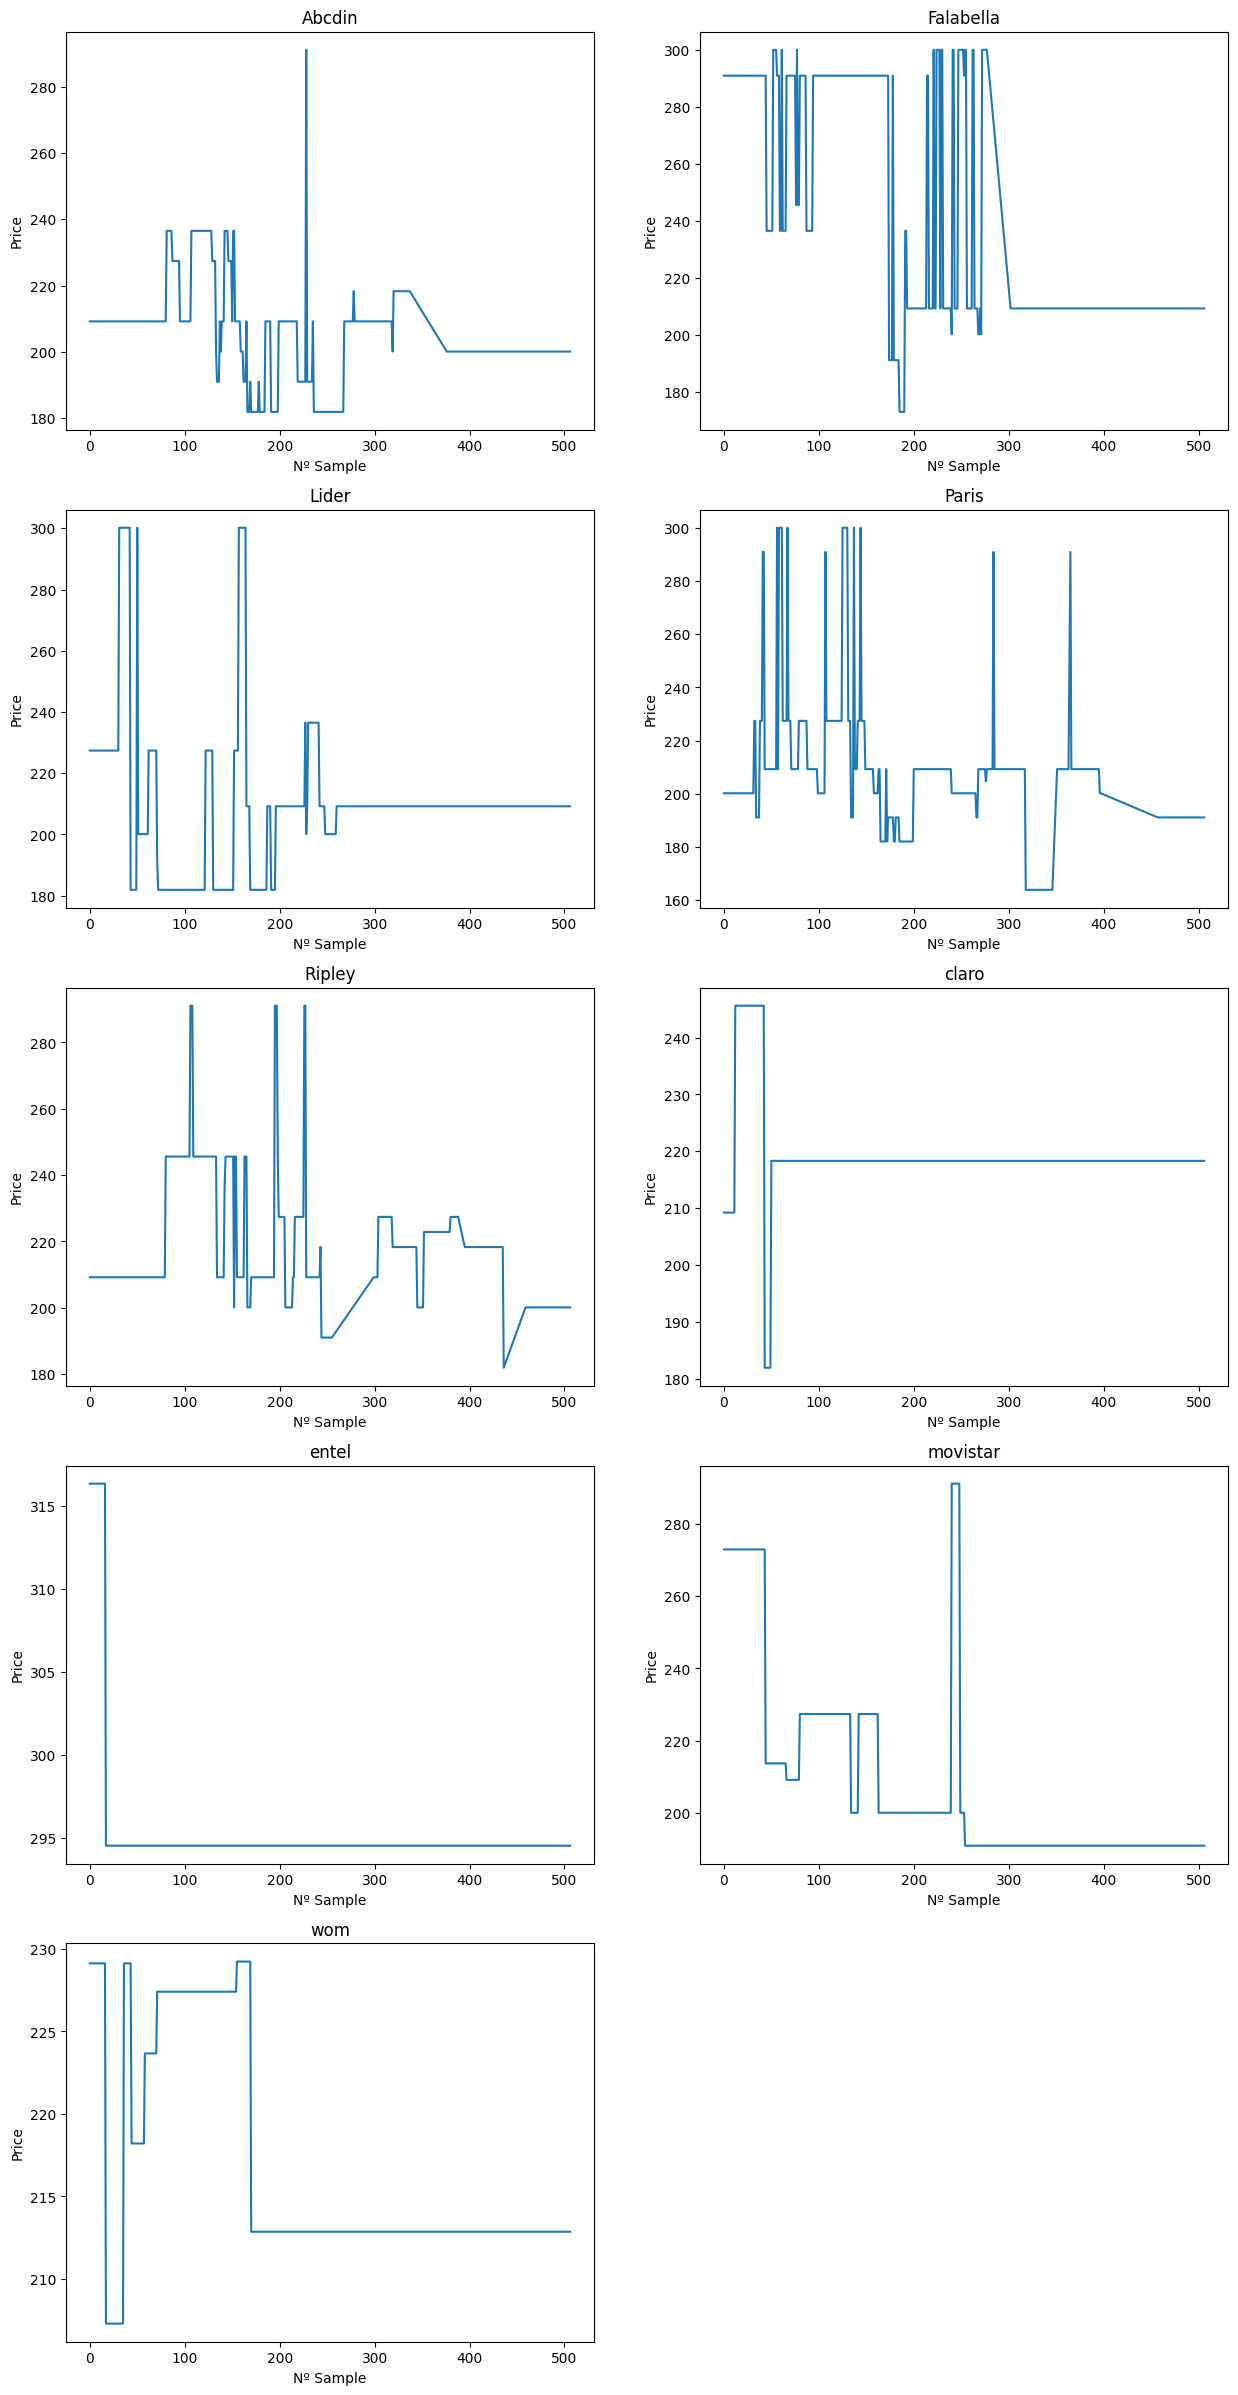

In [9]:
df_wide.columns
values = df_wide.values

# plot each column
columns = [0, 1, 2, 3, 4, 5, 6, 7, 8]
i = 1
plt.figure()
f = plt.figure(figsize=(15,20))
f = plt.figure(figsize=(15,30))
for col in columns:
    plt.subplot(5, 2, i)
    plt.plot(values[:, col])
    plt.xlabel('Nº Sample')
    plt.ylabel('Price')
    plt.title(df_wide.columns[col])
    i += 1
plt.show()

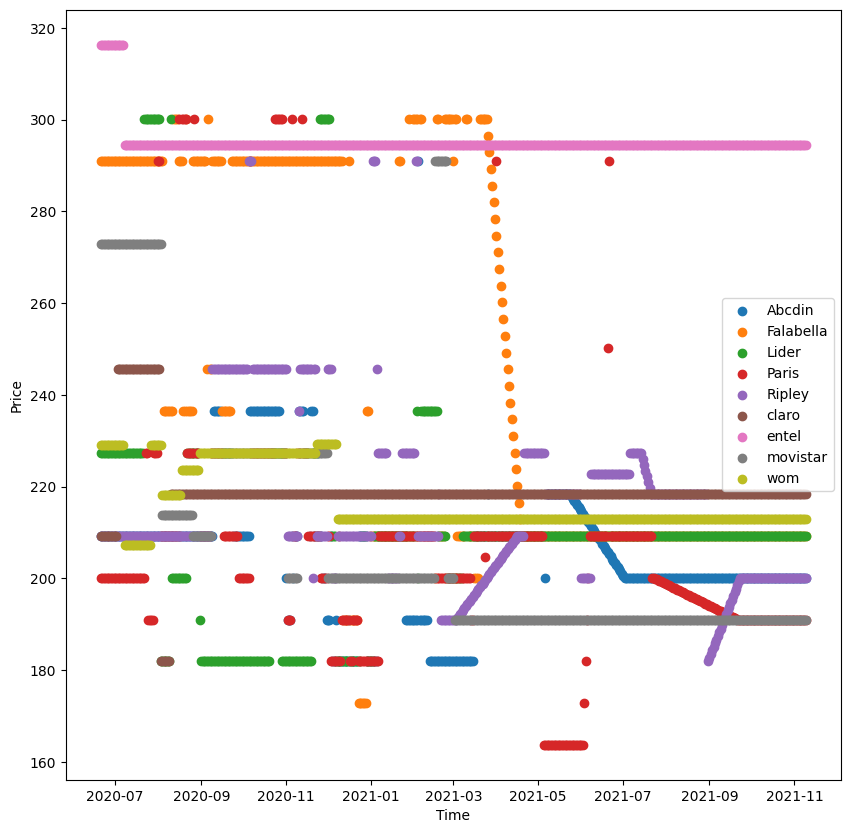

In [10]:
plt.figure(figsize=(10, 10))
for name in df_wide.columns:
    plt.scatter(df_wide.index, df_wide[name])
plt.legend(df_wide.columns)
plt.xlabel('Time')
plt.ylabel('Price')
plt.savefig(path+"product_"+str(product_group_id)+".png",dpi=600,format="png")

# RNN Univariate

In [11]:
raw_seq = df_wide[empresa]

**Function to get X and Y**

In [12]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)

In [13]:
from keras.layers import Dense, SimpleRNN

def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [14]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from keras.optimizers import Adam
from tensorflow import keras
import numpy as np
import tensorflow as tf
import random

min_mape = 10

lag_i = 3
lag_f = 20
split_perc = 0.60   # percentagem para o treino

for i in range(lag_i,lag_f+1):
    #tf.random.set_seed(7)
    random.seed(7)
    
    n_steps = i
    n_features = 1
    X_all, y_all = split_sequence(raw_seq, n_steps)

    split = math.ceil(len(X_all)*split_perc)

    train_X = X_all[:split]
    train_y = y_all[:split]

    test_X = X_all[split:]
    test_y = y_all[split:]

    train_X = train_X.reshape((train_X.shape[0],train_X.shape[1],n_features))
    test_X = test_X.reshape((test_X.shape[0],test_X.shape[1],n_features))

    model = Sequential()

    model.add(SimpleRNN(4, activation='relu', input_shape=(i, n_features), return_sequences = False))
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer='adam', loss='mse')

    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 10)
    history = model.fit(train_X, train_y, epochs=500, batch_size=16, validation_data=(test_X, test_y), verbose=0, shuffle=False, callbacks = [early_stop])

    yhat = model.predict(test_X)

    mse = mean_squared_error(test_y, yhat)
    mae = mean_absolute_error(test_y, yhat)
    mape = mean_absolute_percentage_error(test_y, yhat)

    print('i: %s - MAPE = %.3F - (MSE=%.3f, MAE=%.3f)' % (i, mape, mse, mae))

    if mape < min_mape:
        min_mape = mape
        best_mse = mse
        min_i = i
        best_history = history
        best_yhat = yhat
        best_test_y = test_y
        best_test_x = test_X
        best_mae = mae

print('\nMinimos')
print('Best i: %s - Best MAPE = %.3F - (MSE=%.3f, MAE=%.3f)' % (min_i, min_mape, best_mse, best_mae))



7/7 [==============================] - 0s 1ms/step
i: 3 - MAPE = 0.007 - (MSE=15.237, MAE=1.513)
7/7 [==============================] - 0s 667us/step
i: 4 - MAPE = 0.007 - (MSE=18.764, MAE=1.522)
7/7 [==============================] - 0s 834us/step
i: 5 - MAPE = 0.008 - (MSE=20.774, MAE=1.713)
7/7 [==============================] - 0s 834us/step
i: 6 - MAPE = 0.009 - (MSE=21.943, MAE=1.903)
7/7 [==============================] - 0s 833us/step
i: 7 - MAPE = 0.010 - (MSE=23.294, MAE=1.956)
7/7 [==============================] - 0s 833us/step
i: 8 - MAPE = 0.010 - (MSE=23.816, MAE=2.010)
7/7 [==============================] - 0s 667us/step
i: 9 - MAPE = 0.010 - (MSE=24.353, MAE=2.040)
7/7 [==============================] - 0s 834us/step
i: 10 - MAPE = 0.010 - (MSE=24.660, MAE=2.041)
7/7 [==============================] - 0s 833us/step
i: 11 - MAPE = 0.010 - (MSE=24.876, MAE=2.054)
7/7 [==============================] - 0s 1ms/step
i: 12 - MAPE = 0.010 - (MSE=25.007, MAE=2.058)
7/7 [======

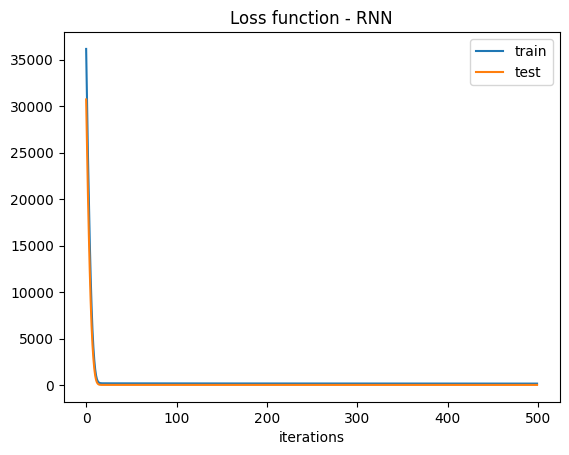

In [15]:
#  print history
pyplot.plot(best_history.history['loss'])
pyplot.plot(best_history.history['val_loss'])
pyplot.title('Loss function - RNN')
pyplot.legend(['train', 'test'])
pyplot.xlabel('iterations')
pyplot.show()

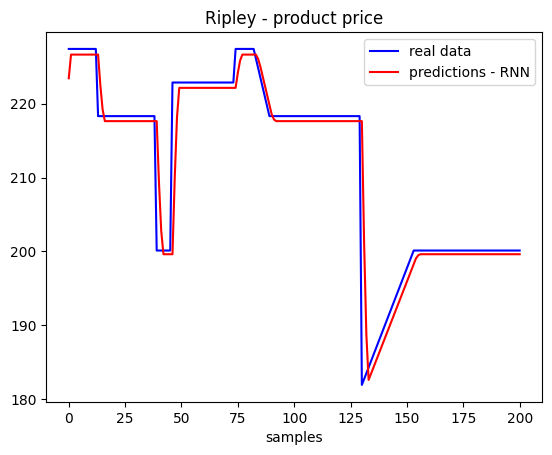

In [16]:
k=test_X.shape[0]

pyplot.figure()
pyplot.plot(best_test_y,color='b', label='real data')
pyplot.plot(best_yhat,color='r', label='predictions - RNN')
pyplot.title("Ripley - product price")
pyplot.xlabel('samples')
pyplot.legend()
pyplot.show()